In [445]:
# Import required libraries for analysis
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
from scipy.optimize import curve_fit
from numpy.polynomial import Polynomial as Poly
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [446]:
# Read dataset using pandas
data_url = 'https://raw.githubusercontent.com/faadeola/us-airline-traffic-analysis/main/air_traffic_data.csv'
airline = pd.read_csv(data_url)

# Display first 10 row of the data
airline.head(10)

,Year,Month,Dom_Pax,Int_Pax,Pax,Dom_Flt,Int_Flt,Flt,Dom_RPM,Int_RPM,RPM,Dom_ASM,Int_ASM,ASM,Dom_LF,Int_LF,LF
0,2003,1,"43,032,450","4,905,830","47,938,280","785,160","57,667","842,827","36,211,422","12,885,980","49,097,402","56,191,300","17,968,572","74,159,872",64.44,71.71,66.20
1,2003,2,"41,166,780","4,245,366","45,412,146","690,351","51,259","741,610","34,148,439","10,715,468","44,863,907","50,088,434","15,587,880","65,676,314",68.18,68.74,68.31
2,2003,3,"49,992,700","5,008,613","55,001,313","797,194","58,926","856,120","41,774,564","12,567,068","54,341,633","57,592,901","17,753,174","75,346,075",72.53,70.79,72.12
3,2003,4,"47,033,260","4,345,444","51,378,704","766,260","55,005","821,265","39,465,980","10,370,592","49,836,572","54,639,679","15,528,761","70,168,440",72.23,66.78,71.02
4,2003,5,"49,152,352","4,610,834","53,763,186","789,397","55,265","844,662","41,001,934","11,575,026","52,576,960","55,349,897","15,629,821","70,979,718",74.08,74.06,74.07
5,2003,6,"52,209,516","5,411,504","57,621,020","798,351","58,225","856,576","44,492,972","13,918,185","58,411,157","56,555,517","17,191,579","73,747,096",78.67,80.96,79.20
6,2003,7,"55,810,773","6,191,120","62,001,893","831,619","62,957","894,576","48,321,924","15,516,794","63,838,718","59,617,048","18,701,759","78,318,807",81.05,82.97,81.51
7,2003,8,"53,920,973","6,272,332","60,193,305","830,737","63,760","894,497","46,982,527","15,906,430","62,888,957","59,634,190","19,144,885","78,779,075",78.78,83.08,79.83
8,2003,9,"44,213,408","4,824,596","49,038,004","781,804","54,017","835,821","36,819,820","13,570,889","50,390,709","54,973,852","17,820,478","72,794,329",66.98,76.15,69.22
9,2003,10,"49,944,931","4,920,822","54,865,753","818,308","54,272","872,580","41,480,412","13,447,446","54,927,858","58,001,020","17,694,417","75,695,437",71.52,76.00,72.56


In [447]:
# Rename columns for clarity
airline = airline.rename(columns={
                                  'Pax' : 'Total Passengers',
                                  'Dom_Flt' : 'Domestic flight',
                                  'Dom_Pax' : 'Domestic pax',
                                  'Int_Pax' : 'International pax',
                                  'Int_Flt' : 'International flight',
                                  'Flt' : 'Total flight',
                                  'RPM' : 'Revenue per Miles',
                                  'ASM' : 'Available Seat per Miles',
                                  'Dom_LF' : 'Domestic Load Factor',
                                  'Int_LF' : 'International Load Factor',
                                  'LF' : 'Total Load Factor',
                                  'Int_RPM' : 'International RPM',
                                  'Dom_ASM' : 'Domestic ASM'
                                })

# Set specific column to appropriate data type
col_to_convert = ['Domestic pax', 'International pax', 'Total Passengers', 'Domestic flight', 'International flight', 'Total flight',
                   'Domestic RPM', 'International RPM', 'Revenue per Miles', 'Available Seat per Miles', 'Domestic ASM', 'International ASM']

for col in col_to_convert:
    if col in airline.columns:
        airline[col] = airline[col].str.replace(',','').astype(int)

In [448]:
# Extract column of interest back to dataset
columns_airline = ['Year', 'Total Passengers', 'Total flight', 'Revenue per Miles', 'Available Seat per Miles', 'Total Load Factor']
airline = airline[columns_airline]

In [449]:
# Since Year 2023 does not have complete 12 months data, remove it
airline = airline[airline['Year'] != 2023]

In [450]:
''' 
Display information about the data:
columns, count of cell that are not empty (non-null) and the data type of each column
'''
print(airline.info(), end='\n\n')

# View basic statistics about the dataset
print(airline.describe().round(2))

<class 'pandas.core.frame.DataFrame'>
Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Year                      240 non-null    int64  
 1   Total Passengers          240 non-null    int64  
 2   Total flight              240 non-null    int64  
 3   Revenue per Miles         240 non-null    int64  
 4   Available Seat per Miles  240 non-null    int64  
 5   Total Load Factor         240 non-null    float64
dtypes: float64(1), int64(5)
memory usage: 13.1 KB
None

          Year  Total Passengers  Total flight  Revenue per Miles  \
count   240.00            240.00        240.00       2.400000e+02   
mean   2012.50       62022603.36     773513.60       6.797282e+07   
std       5.78       12062741.34     117076.67       1.510492e+07   
min    2003.00        3013899.00     222280.00       2.907889e+06   
25%    2007.75       57450646.75     730990.25       6.1219

In [451]:
def plot_histogram(col):

    '''
    Create an histogram plot for any specified column
    '''
    
    fig, ax = plt.subplots(dpi=144)

    # The kde (kernel density estimate) argument set to True shows shape of the distribution on the plot
    sns.histplot(col, bins=15, color='blue', edgecolor='black', kde=True)
    
    # Draw a vertical line on the mean and median point of the specified column
    plt.axvline(col.mean(), color='red', lw=1.5, ls='--', label= f'Mean: {col.mean():.2f}')
    plt.axvline(col.median(), color='orange', lw=1, ls='-', label= f'Median: {col.median():.2f}')
    
    # Annotate skewness and kurtosis value of distribution
    plt.annotate(f'Skewness: {ss.skew(col):.2f}', 
                 xy=(col.min()-2, (col.max() - col.min() + col.min()))
                )
    
    plt.annotate(f'Kurtosis: {ss.kurtosis(col, fisher=False):.2f}', 
                 xy=(col.min()-2, (col.max() - col.min() + col.min() - np.random.randint(5,10,1)))
                )
    
    plt.annotate(f'Standard Dev.: {np.std(col):.2f}', 
                 xy=(col.min()-2, (col.max() - col.min() + col.min() - np.random.randint(10,20,1)))
                )
    
    # Set plot attributes (label, title and ticks)
    plt.xlabel(col.name, labelpad=10, fontsize=10)
    plt.ylabel('Frequency', labelpad=10, fontsize=10)
    plt.title(f'Distribution of {col.name}', fontsize= 12, fontweight='bold', pad=14)
    ax.tick_params(axis='both', labelsize=8)
    plt.legend(loc='upper left')
    plt.grid(axis='y', alpha=0.3)
    plt.show()
    return

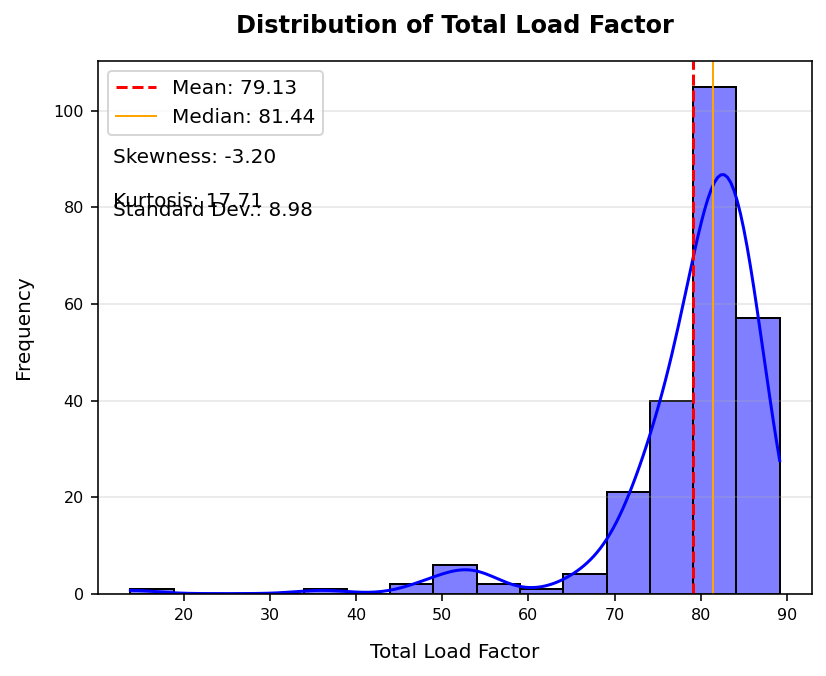

In [452]:
plot_histogram(airline['Total Load Factor'])

In [453]:
def plot_scatter(x_col,y_col):
    '''
    Create a scatter plot between two columns
    '''

    fig, ax = plt.subplots(dpi=144)
    plt.scatter(x_col,y_col, color='red', marker='o', alpha=0.4, label=y_col.name)
    
    # Set the plot attributes (labels, title, grid and ticks)
    plt.xlabel(x_col.name, labelpad=10, fontsize=10)
    plt.ylabel(f'{y_col.name} (x10000000)', labelpad=10, fontsize=10)
    plt.title(f'Scatter plot of \n{x_col.name} vs {y_col.name}',fontsize=10, fontweight='bold', pad=14)
    plt.grid(axis='both', color='lightgray', alpha=0.3)
    ax.tick_params(axis='both', labelsize=8)
    
    plt.tight_layout()
    plt.legend()
    #plt.savefig(f'{x_col.name} vs {y_col.name}.png')

    plt.show()
    return

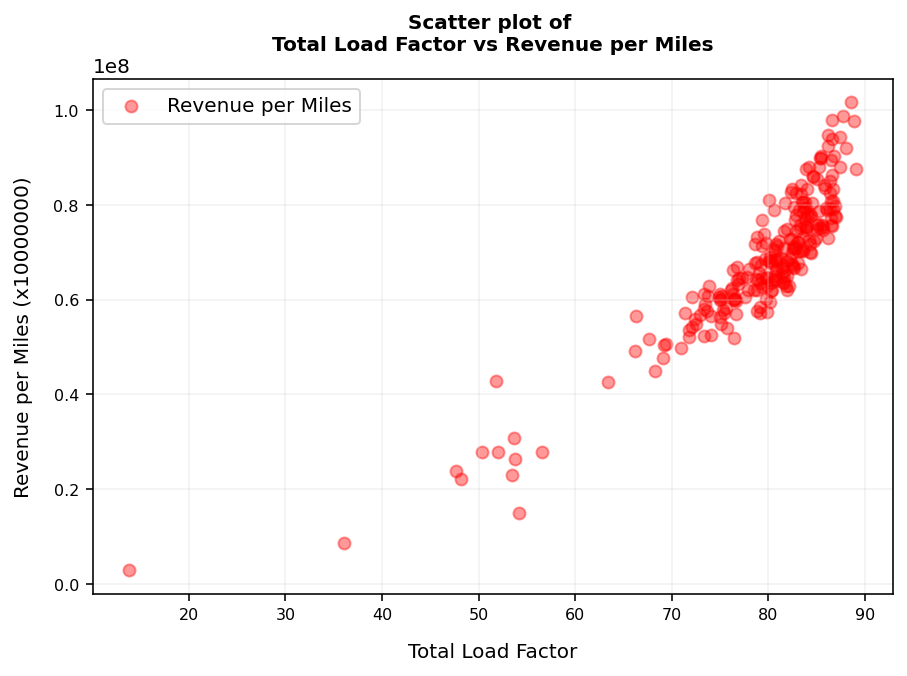

In [454]:
plot_scatter(airline['Total Load Factor'],  airline['Revenue per Miles'])

In [455]:
def plot_corr_hmap(data):
    '''
    Plot the heatmap for the gym dataframe 
    using the Seaborn Library and Pearson's method
    '''
    # Get correlation values of the dataset
    data_corr = data.corr(method='pearson', numeric_only=True)
    
    # Set mask to hide the upper repetition of data in the heatmap
    hmask = np.triu(np.ones_like(data_corr))

    # Plotting the heatmap
    plt.figure(figsize=(14,8),dpi=144)
    sns.heatmap(data_corr, cmap='coolwarm', annot=True, lw=1.5, mask=hmask, vmin=-1, vmax=1)
    
    # Set plot attributes
    plt.title(f'Heatmap of Airline Dataset', fontsize=14, fontweight='bold', pad=14, loc='left')
    plt.tick_params(axis='both', labelsize=12)

    plt.show()
    return

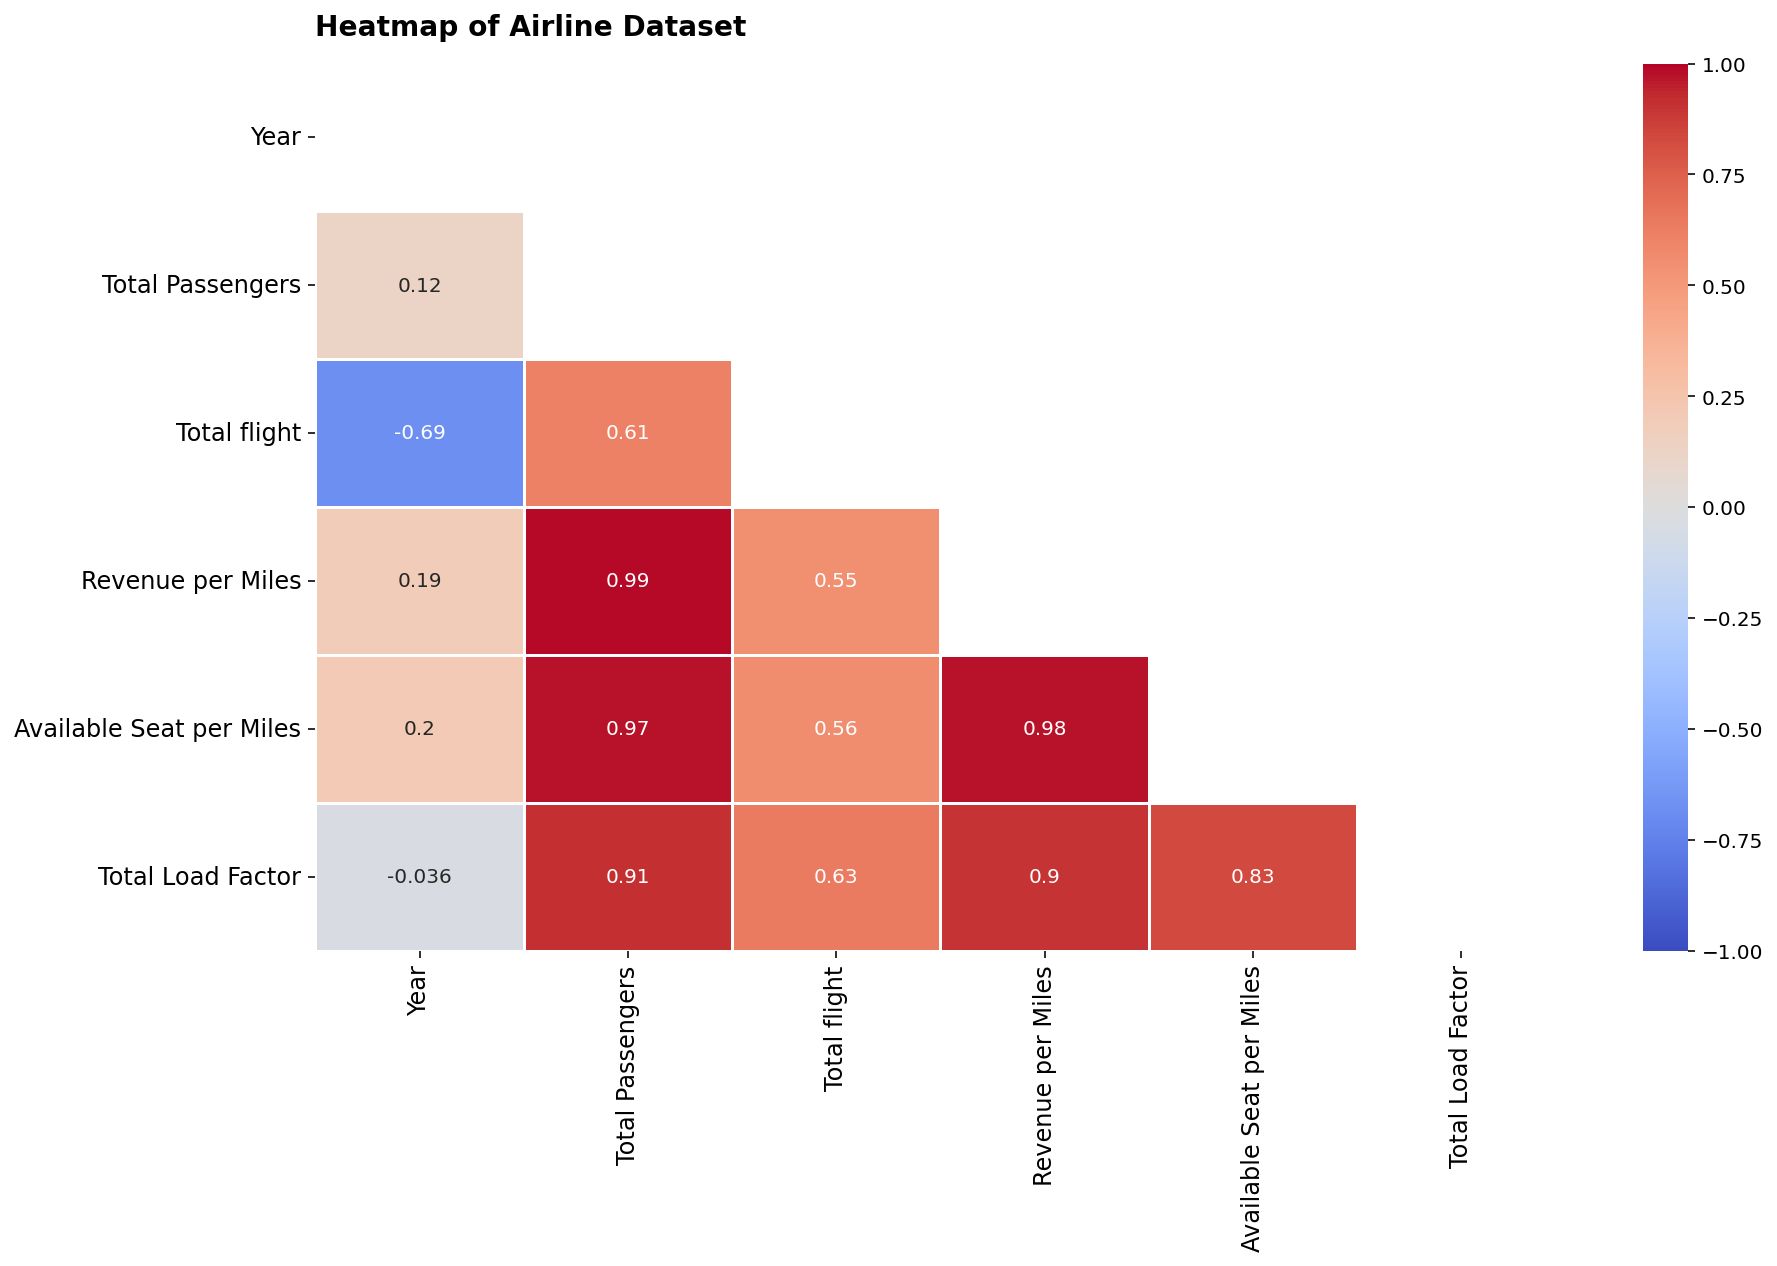

In [456]:
# Display heatmap of correlation
plot_corr_hmap(airline)

In [457]:
total_revenue = airline.groupby('Year')['Revenue per Miles'].mean().reset_index()

In [458]:
# Define exponential function
def exponential(t, n0, g):
    """
    Calculates exponential function with scale factor n0 and growth rate g.
    """
    
    f = n0 * np.exp(g*t)
    
    return f

# Define logistic function
def logistic(t, n0, g, t0):
    """
    Calculates the logistic function with scale factor n0 and growth rate g
    """
    
    f = n0 / (1 + np.exp(-g*(t - t0)))
    
    return f

In [469]:
def fit_data(x_col, y_col):
    '''
    Perform normalization, fitting and determine variables
    '''
    y_value = y_col.values
    norm_x = (x_col - np.median(x_col)).values
    norm_y = (y_col - np.median(y_col)).values
    
    
    # Give some initial guesses of N0 and growth for exponential fitting
    p, cov = curve_fit(exponential, norm_x, y_value,
                  p0=(np.max(y_value), 0.3))

    # get uncertainties on each parameter
    sigma = np.sqrt(np.diag(cov))

    print('Values for Exponential Fit:', end='\n\n\n')
    print(f"N0 = {p[0]:g} +/- {sigma[0]:g}")
    print(f"g = {p[1]:.2f} +/- {sigma[1]:.2f}", end='\n\n\n')
    
    # Add new column with values of exponential fit
    total_revenue['Exponential Fit'] = exponential(norm_x, *p)
    
    
    # Give some intial guess for logistic fitting
    p, cov = curve_fit(logistic, norm_x, y_value,
                  p0=(np.max(y_value), 0.03, 10))
    sigma_log = np.sqrt(np.diag(cov))
    print('Values for Logistic Fit:')
    print(f"N0 = {p[0]:g} +/- {sigma_log[0]:g}")
    print(f"g = {p[1]:.2f} +/- {sigma_log[1]:.2f}")
    print(f"t0 = {p[2] + np.median(x_col):.2f} +/- {sigma_log[2]:.2f}")
    
   # Add new column with values of logistic fit 
    total_revenue['Logistic Fit'] = logistic(norm_x, *p)
    return
    

def fit_data(x_col, y_col):
    '''
    Perform normalization, fitting and determine variables
    '''
    
    scaler = MinMaxScaler()
    x_value = x_col.values.reshape(-1,1)
    y_value = y_col.values
    norm_x =  scaler.fit_transform(x_value).flatten()
    
    
    # Give some initial guesses of N0 and growth for exponential fitting
    p, cov = curve_fit(exponential, norm_x, y_value,
                  p0=(np.max(y_value), 0.3))

    # get uncertainties on each parameter
    sigma = np.sqrt(np.diag(cov))

    print(f"N0 = {p[0]:g} +/- {sigma[0]:g}")
    print(f"g = {p[1]:.2f} +/- {sigma[1]:.2f}")
    
    # Add new column with values of exponential fit
    airline['Exponential Fit'] = exponential(norm_x, *p)
    return
    

In [470]:
fit_data(total_revenue['Year'], total_revenue['Revenue per Miles'])

Values for Exponential Fit:


N0 = 6.79206e+07 +/- 2.71999e+06
g = 0.01 +/- 0.01


Values for Logistic Fit:
N0 = 7.06867e+07 +/- 4.15632e+06
g = 0.36 +/- 0.52
t0 = 1999.35 +/- 6.59


In [471]:
def plot_fitted_data():
    '''
    Plot the heatmap for the gym dataframe 
    using the Seaborn Library and Pearson's method
    '''
    fig, ax = plt.subplots(dpi=144)
    
    # Get correlation values of the dataset
    
    plt.plot(total_revenue['Year'], total_revenue['Revenue per Miles'], lw=2, label ='Revenue per Miles')
    plt.plot(total_revenue['Year'], total_revenue['Exponential Fit'], lw=2, label ='Exponential Fit')  
    plt.plot(total_revenue['Year'], total_revenue['Logistic Fit'], lw=2, label ='Logistic Fit')  
    
    # Set plot attributes
    #plt.title(f'Heatmap of Airline Dataset', fontsize=14, fontweight='bold', pad=14, loc='left')
    plt.tick_params(axis='both', labelsize=12)
    plt.legend()

    plt.show()
    return

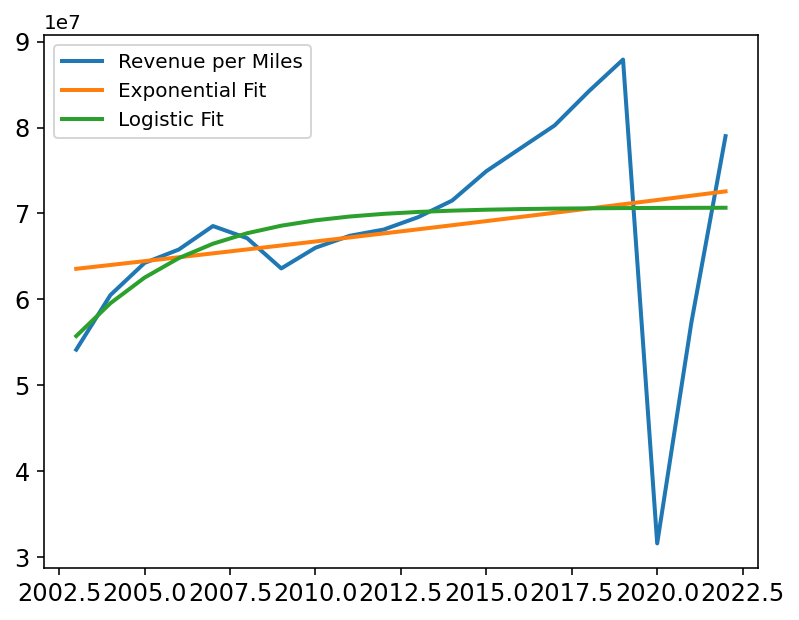

In [472]:
plot_fitted_data()